# DCGAN with MNIST

* MNIST data를 가지고 **Deep Convolution GAN**를 `tf.contrib.slim`을 이용하여 만들어보자.
  * [참고: TensorFlow slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim)

In [2]:
#Connected google drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [0]:
#make data directory
!mkdir -p drive
!google-drive-ocamlfuse drive

## Import modules

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline


import tensorflow as tf

slim = tf.contrib.slim
tf.logging.set_verbosity(tf.logging.INFO)

#tf.set_random_seed(219)
#np.random.seed(219)

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [0]:
!cd ./drive/gan/BEGAN-tensorflow-master/data/

In [0]:
# Training Flags (hyperparameter configuration)
train_dir = './drive/gan/BEGAN-tensorflow-master/data/sample/'
max_epochs = 5000
save_epochs = 100
summary_steps = 100
print_steps = 100
batch_size = 128
learning_rate_D = 0.001
learning_rate_G = 0.001
k = 1 # the number of step of learning D before learning G
num_samples = 16

epoch = 0

## Import MNIST

In [0]:
import os
import cv2

In [0]:
train_data = np.load('./drive/gan/train_data_4.npy')

In [28]:
train_data.shape

(854, 28, 28, 3)

## Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [8]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.repeat(count=max_epochs)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

<BatchDataset shapes: (?, 28, 28, 3), types: tf.float64>


## Create the model

In [0]:
class DCGAN(object):
  """Deep Convolutional Generative Adversarial Networks
  implementation based on http://arxiv.org/abs/1511.06434
  
  "Unsupervised Representation Learning with
  Deep Convolutional Generative Adversarial Networks"
  Alec Radford, Luke Metz and Soumith Chintala
  """
  
  def __init__(self, mode, train_dataset, test_dataset=None):
    """Basic setup.
    
    Args:
      mode (`string`): "train" or "generate".
      train_dataset (`tf.data.Dataset`): train_dataset.
      test_dataset (`tf.data.Dataset`): test_dataset.
    """
    assert mode in ["train", "generate"]
    self.mode = mode
    
    # hyper-parameters for model
    self.x_dim = 28
    self.z_dim = 100
    self.batch_size = batch_size
    self.num_samples = num_samples
    self.train_dataset = train_dataset
    self.test_dataset = test_dataset
    
    # Global step Tensor.
    self.global_step = None
    
    print('The mode is %s.' % self.mode)
    print('complete initializing model.')
    
    
  def build_random_z_inputs(self):
    """Build a vector random_z in latent space.
    
    Returns:
      self.random_z (`4-rank Tensor` with [batch_size, 1, 1, z_dim]):
          latent vector which size is generally 100 dim.
      self.sample_random_z (`4-rank Tensor` with [num_samples, 1, 1, z_dim]):
          latent vector which size is generally 100 dim.
    """
    # Setup variable of random vector z
    with tf.variable_scope('random_z'):
      self.random_z = tf.random_normal(shape=[self.batch_size, 1, 1, self.z_dim])
                                        
      self.sample_random_z = tf.random_normal(shape=[self.num_samples, 1, 1, self.z_dim])
                                               

    return self.random_z, self.sample_random_z
  
  
  def read_MNIST(self, dataset):
    """Read MNIST dataset
    
    Args:
      dataset (`tf.data.Dataset` format): MNIST dataset.
      
    Returns:
      self.mnist (`4-rank Tensor` with [batch, x_dim, x_dim, 1]): MNIST dataset with batch size.
    """
    with tf.variable_scope('mnist'):
      iterator = dataset.make_one_shot_iterator()

      self.mnist = iterator.get_next()
      self.mnist = tf.cast(self.mnist, dtype = tf.float32)
      #self.mnist = tf.expand_dims(self.mnist, axis=3)
      
    return self.mnist


  def Generator(self, random_z, is_training=True, reuse=False):
    """Generator setup.
    
    Args:
      random_z (`2-rank Tensor` with [batch_size, z_dim]):
          latent vector which size is generally 100 dim.
      is_training (`bool`): whether training mode or test mode.
      reuse (`bool`): whether variable reuse or not.
      
    Returns:
      generated_data (`4-rank Tensor` with [batch_size, h, w, c])
          generated images from random vector z.
    """
    with tf.variable_scope('Generator', reuse=reuse) as scope:
      batch_norm_params = {'decay': 0.9,
                           'epsilon': 0.001,
                           'is_training': is_training,
                           'scope': 'batch_norm'}
      with slim.arg_scope([slim.conv2d_transpose],
                          kernel_size=[4, 4],
                          stride=[2, 2],
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=batch_norm_params):
        
        # Use full conv2d_transpose instead of projection and reshape
        # random_z: 1 x 1 x 100 dim
        self.inputs = random_z
        # inputs = random_z: 1 x 1 x 100 dim
        # outputs: 3 x 3 x 256 dim
        self.layer1 = slim.conv2d_transpose(inputs=self.inputs,
                                            num_outputs=256,
                                            kernel_size=[3, 3],
                                            padding='VALID',
                                            scope='layer1')
        # inputs: 3 x 3 x 256 dim
        # outputs: 7 x 7 x 128 dim
        self.layer2 = slim.conv2d_transpose(inputs=self.layer1,
                                            num_outputs=128,
                                            kernel_size=[3, 3],
                                            padding='VALID',
                                            scope='layer2')
        # inputs: 7 x 7 x 128 dim
        # outputs: 14 x 14 x 64 dim
        self.layer3 = slim.conv2d_transpose(inputs=self.layer2,
                                            num_outputs=64,
                                            scope='layer3')
        # inputs: 14 x 14 x 64 dim
        # outputs: 28 x 28 x 1 dim
        self.layer4 = slim.conv2d_transpose(inputs=self.layer3,
                                            num_outputs=3,
                                            normalizer_fn=None,
                                            activation_fn=tf.sigmoid,
                                            scope='layer4')
        # generated_data = outputs: 28 x 28 x 3 dim
        generated_data = self.layer4

        return generated_data
    
    
  def Discriminator(self, data, reuse=False):
    """Discriminator setup.
    
    Args:
      data (`2-rank Tensor` with [batch_size, x_dim]): MNIST real data.
      reuse (`bool`): whether variable reuse or not.
      
    Returns:
      logits (`1-rank Tensor` with [batch_size]): logits of data.
    """
    with tf.variable_scope('Discriminator', reuse=reuse) as scope:
      batch_norm_params = {'decay': 0.9,
                           'epsilon': 0.001,
                           'scope': 'batch_norm'}
      with slim.arg_scope([slim.conv2d],
                          kernel_size=[4, 4],
                          stride=[2, 2],
                          activation_fn=tf.nn.leaky_relu,
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=batch_norm_params):
        
        # inputs = data: 28 x 28 x 1 dim
        #self.input = slim.flatten(inputs=data, scope='flatten')
        # outputs: 14 x 14 x 64 dim
        self.layer1 = slim.conv2d(inputs=data,
                                  num_outputs=64,
                                  normalizer_fn=None,
                                  scope='layer1')
        # inputs: 14 x 14 x 64 dim
        # outputs: 7 x 7 x 128 dim
        self.layer2 = slim.conv2d(inputs=self.layer1,
                                  num_outputs=128,
                                  scope='layer2')
        # inputs: 7 x 7 x 128 dim
        # outputs: 3 x 3 x 256 dim
        self.layer3 = slim.conv2d(inputs=self.layer2,
                                  num_outputs=256,
                                  kernel_size=[3, 3],
                                  padding='VALID',
                                  scope='layer3')
        # inputs: 3 x 3 x 256 dim
        # outputs: 1 x 1 x 1 dim
        self.layer4 = slim.conv2d(inputs=self.layer3,
                                  num_outputs=1,
                                  kernel_size=[3, 3],
                                  stride=[1, 1],
                                  padding='VALID',
                                  normalizer_fn=None,
                                  activation_fn=None,
                                  scope='layer4')
        # logits = layer4: 1 x 1 x 1 dim -> 1 dim
        discriminator_logits = tf.squeeze(self.layer4, axis=[1, 2])

        return discriminator_logits
    
    
  def setup_global_step(self):
    """Sets up the global step Tensor."""
    if self.mode == "train":
      self.global_step = tf.train.get_or_create_global_step()
      
      print('complete setup global_step.')
      
      
  def GANLoss(self, logits, is_real=True, scope=None):
    """Computes standard GAN loss between `logits` and `labels`.
    
    Args:
      logits (`1-rank Tensor`): logits.
      is_real (`bool`): True means `1` labeling, False means `0` labeling.
      
    Returns:
      loss (`0-randk Tensor): the standard GAN loss value. (binary_cross_entropy)
    """
    if is_real:
      labels = tf.ones_like(logits)
    else:
      labels = tf.zeros_like(logits)

    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=labels,
                                           logits=logits,
                                           scope=scope)

    return loss

      
  def build(self):
    """Creates all ops for training or generate."""
    self.setup_global_step()
    
    if self.mode == "generate":
      pass
    
    else:
      # generating random vector
      self.random_z, self.sample_random_z = self.build_random_z_inputs()
      # read dataset
      self.real_data = self.read_MNIST(self.train_dataset)
      
      # generating images from Generator() via random vector z
      self.generated_data = self.Generator(self.random_z)
      
      # discriminating real data by Discriminator()
      self.real_logits = self.Discriminator(self.real_data)
      # discriminating fake data (generated)_images) by Discriminator()
      self.fake_logits = self.Discriminator(self.generated_data, reuse=True)
      
      # losses of real with label "1"
      self.loss_real = self.GANLoss(self.real_logits, is_real=True, scope='loss_D_real')
      # losses of fake with label "0"
      self.loss_fake = self.GANLoss(self.fake_logits, is_real=False, scope='loss_D_fake')
      
      # losses of Discriminator
      with tf.variable_scope('loss_D'):
        self.loss_Discriminator = self.loss_real + self.loss_fake
        
      # losses of Generator with label "1" that used to fool the Discriminator
      self.loss_Generator = self.GANLoss(self.fake_logits, is_real=True, scope='loss_G')
      
      # Separate variables for each function
      self.D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')
      self.G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
      
      
      # generating images for sample
      self.sample_data = self.Generator(self.sample_random_z, is_training=False, reuse=True)
      
      # write summaries
      # Add loss summaries
      tf.summary.scalar('losses/loss_Discriminator', self.loss_Discriminator)
      tf.summary.scalar('losses/loss_Generator', self.loss_Generator)
      
      # Add histogram summaries
      for var in self.D_vars:
        tf.summary.histogram(var.op.name, var)
      for var in self.G_vars:
        tf.summary.histogram(var.op.name, var)
      
      # Add image summaries
      tf.summary.image('random_images', self.generated_data, max_outputs=4)
      tf.summary.image('real_images', self.real_data)
      
    print('complete model build.\n')

## Define plot function

In [0]:
def print_sample_data(sample_data, global_step_, epochs, max_print=num_samples):
  #sample_data = sample_data * 255
  #sample_data = sample_data.astype(np.int)
  print_images = sample_data[:max_print,:]
  print_images = print_images.reshape([max_print, 28, 28, 3])
  print_images = print_images.swapaxes(0, 1)
  print_images = print_images.reshape([28, max_print * 28, 3])
  
  plt.figure(figsize=(max_print, 1))
  plt.axis('off')
  plt.imshow(print_images)
  plt.show()
  
  str = np.str('./drive/gan/BEGAN-tensorflow-master/data/sample/img(' + np.str(global_step_) + 'epochs : ' + np.str(epochs) + ').jpg')
  cv2.imwrite(str, print_images)

In [0]:
def save_sample_data(sample_data, global_step_, epochs, max_print=num_samples):
  print_images = sample_data[:max_print,:]
  print_images = print_images.reshape([max_print, 28, 28])
  print_images = print_images.swapaxes(0, 1)
  print_images = print_images.reshape([28, max_print * 28])
  str = './drive/gan/BEGAN-tensorflow-master/data/sample/img(' + np.str(global_step_) + 'epochs : ' + np.str(epochs) + ').jpg'
  cv2.imwrite(str, sample_data)

## Build a model

In [0]:
tf.reset_default_graph()

In [46]:
model = DCGAN(mode="train", train_dataset=train_dataset)
model.build()

# show info for trainable variables
t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

The mode is train.
complete initializing model.
complete setup global_step.
complete model build.

---------
Variables: name (type shape) [size]
---------
Generator/layer1/weights:0 (float32_ref 3x3x256x100) [230400, bytes: 921600]
Generator/layer1/batch_norm/beta:0 (float32_ref 256) [256, bytes: 1024]
Generator/layer2/weights:0 (float32_ref 3x3x128x256) [294912, bytes: 1179648]
Generator/layer2/batch_norm/beta:0 (float32_ref 128) [128, bytes: 512]
Generator/layer3/weights:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
Generator/layer3/batch_norm/beta:0 (float32_ref 64) [64, bytes: 256]
Generator/layer4/weights:0 (float32_ref 4x4x3x64) [3072, bytes: 12288]
Generator/layer4/biases:0 (float32_ref 3) [3, bytes: 12]
Discriminator/layer1/weights:0 (float32_ref 4x4x3x64) [3072, bytes: 12288]
Discriminator/layer1/biases:0 (float32_ref 64) [64, bytes: 256]
Discriminator/layer2/weights:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
Discriminator/layer2/batch_norm/beta:0 (float32_ref 128

(1091716, 4366864)

In [0]:
def rate_D(epoch):
    if epoch >= 2500:
        learning_rate_D = 0.01
    elif epoch < 2500 and epoch >= 1000 :
        learning_rate_D = 0.05
    else :
        learning_rate_D = 0.001
        
    return learning_rate_D
  
def rate_G(epoch):
    if epoch >= 2500:
        learning_rate_G = 0.01
    elif epoch < 2500 and epoch >= 1000 :
        learning_rate_G = 0.05
    else :
        learning_rate_G = 0.001
        
    return learning_rate_G

In [0]:
opt_D = tf.train.AdamOptimizer(learning_rate=rate_D(epoch), beta1=0.5)
opt_G = tf.train.AdamOptimizer(learning_rate=rate_G(epoch), beta1=0.5)

In [0]:
# 여기를 채워 넣으세요
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')):
  opt_D_op = opt_D.minimize(model.loss_Discriminator, var_list=model.D_vars)
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')):
  opt_G_op = opt_G.minimize(model.loss_Generator, global_step=model.global_step,
                            var_list=model.G_vars)
  

### Assign `tf.summary.FileWriter`

In [49]:
graph_location = train_dir
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph()) 

Saving graph to: ./drive/gan/BEGAN-tensorflow-master/data/sample/


### `tf.summary`

In [0]:
summary_op = tf.summary.merge_all()

### `tf.train.Saver`

In [0]:
saver = tf.train.Saver(tf.global_variables(), max_to_keep=1000)

### `tf.Session` and train

In [0]:
import cv2

INFO:tensorflow:Start Session.
Epochs: 0.00 global_step: 0 loss_D: 1.822 loss_G: 0.000 (96.21 examples/sec; 1.330 sec/batch)


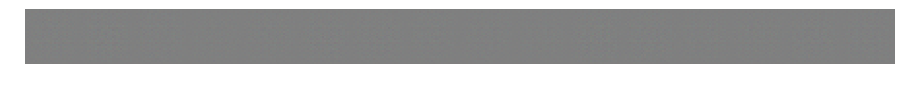

generated_data


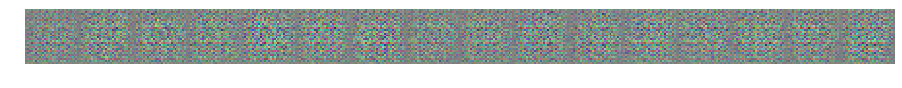

Epochs: 14.99 global_step: 100 loss_D: 2.092 loss_G: 1.016 (2061.18 examples/sec; 0.062 sec/batch)


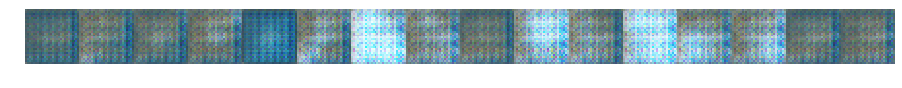

generated_data


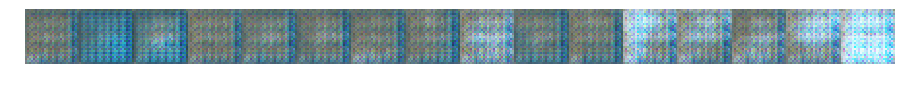

Epochs: 29.98 global_step: 200 loss_D: 0.991 loss_G: 1.199 (2081.54 examples/sec; 0.061 sec/batch)


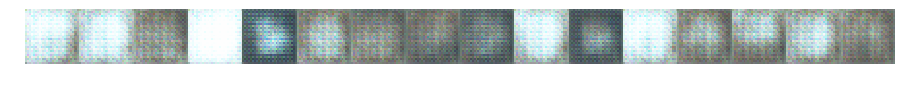

generated_data


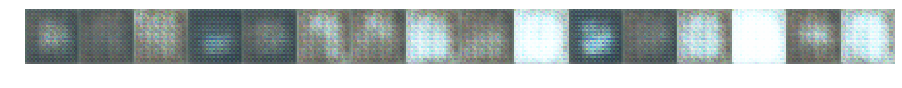

Epochs: 44.96 global_step: 300 loss_D: 1.172 loss_G: 1.254 (2057.09 examples/sec; 0.062 sec/batch)


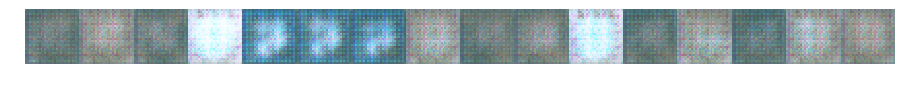

generated_data


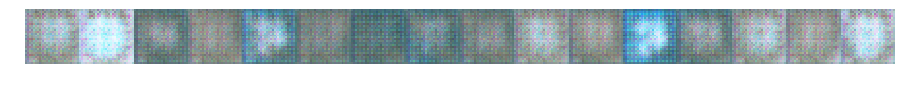

Epochs: 59.95 global_step: 400 loss_D: 0.914 loss_G: 1.087 (2083.83 examples/sec; 0.061 sec/batch)


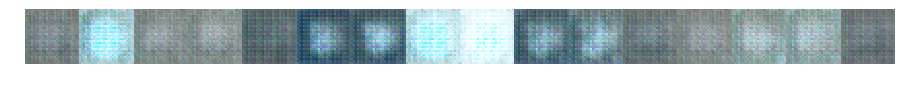

generated_data


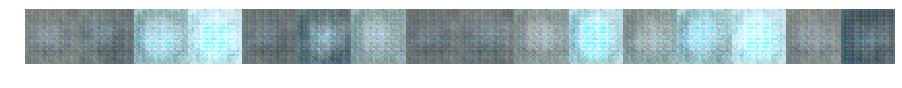

Epochs: 74.94 global_step: 500 loss_D: 1.239 loss_G: 0.695 (2101.08 examples/sec; 0.061 sec/batch)


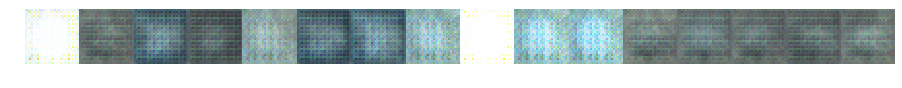

generated_data


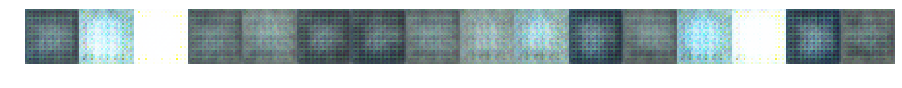

Epochs: 89.93 global_step: 600 loss_D: 0.991 loss_G: 1.360 (2084.21 examples/sec; 0.061 sec/batch)


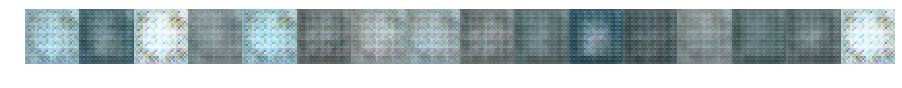

generated_data


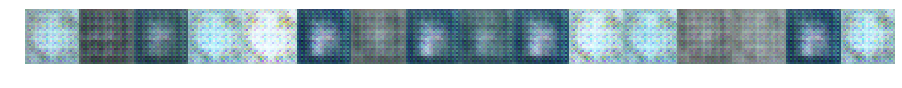

INFO:tensorflow:Saving model with global step 668 (= 100 epochs) to disk.


In [0]:
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
with tf.Session(config=sess_config) as sess:
  sess.run(tf.global_variables_initializer())
  tf.logging.info('Start Session.')
  
  num_examples = len(train_data)
  num_batches_per_epoch = int(num_examples / batch_size) # 704 / 64
  
  # save loss values for plot
  loss_history = []
  pre_epochs = 0
  while True:
    try:
      start_time = time.time()
      
      for _ in range(k):
        _, loss_D = sess.run([opt_D_op, model.loss_Discriminator])
      _, global_step_, loss_G = sess.run([opt_G_op,
                                          model.global_step,
                                          model.loss_Generator])
      #print('global_step_ :', global_step_)
      epochs = global_step_ * batch_size / float(num_examples)
      duration = time.time() - start_time

      if global_step_ % print_steps == 0:
        examples_per_sec = batch_size / float(duration)
        print("Epochs: {:.2f} global_step: {} loss_D: {:.3f} loss_G: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                  epochs, global_step_, loss_D, loss_G, examples_per_sec, duration))

        loss_history.append([epochs, loss_D, loss_G])

        # print sample data
        sample_data = sess.run(model.sample_data)
        generated_data = sess.run(model.generated_data)
        print_sample_data(sample_data, global_step_, epochs)
        print('generated_data')
        print_sample_data(generated_data, global_step_, epochs)
        #save_sample_data(generated_data)

      # write summaries periodically
      if global_step_ % summary_steps == 0:
        summary_str = sess.run(summary_op)
        train_writer.add_summary(summary_str, global_step=global_step_)

      # save model checkpoint periodically
      if int(epochs) % save_epochs == 0  and  pre_epochs != int(epochs):
        tf.logging.info('Saving model with global step {} (= {} epochs) to disk.'.format(global_step_, int(epochs)))
        saver.save(sess, train_dir + 'model.ckpt', global_step=global_step_)
        pre_epochs = int(epochs)
        
    except tf.errors.OutOfRangeError:
      print("End of dataset")  # ==> "End of dataset"
      tf.logging.info('Saving model with global step {} (= {} epochs) to disk.'.format(global_step_, int(epochs)))
      saver.save(sess, train_dir + 'model.ckpt', global_step=global_step_)
      break
      
  tf.logging.info('complete training...')

## Plot loss functions

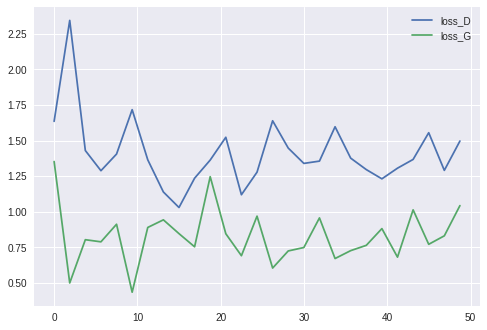

In [23]:
loss_history = np.asarray(loss_history)

plt.plot(loss_history[:,0], loss_history[:,1], label='loss_D')
plt.plot(loss_history[:,0], loss_history[:,2], label='loss_G')
plt.legend(loc='upper right')
plt.show()

In [27]:
print(loss_history[:,2])

[2.71165705 1.87907851 1.14140928 1.48329878]


In [28]:
print(loss_history[:,0])

[ 0.          9.09090909 18.18181818 27.27272727]


In [0]:
  str = './drive/gan/BEGAN-tensorflow-master/data/sample/a.jpg'
  cc = cv2.imread(str)
  cc = np.asarray(cc)

In [0]:
cc = np.asarray(cc)

In [0]:
 str = './drive/gan/BEGAN-tensorflow-master/data/sample/a.jpg'
cv2.imwrite(str,cc)

True